In [1]:
import sys

sys.path.append("..")

In [2]:
import time
from functools import partial
from textwrap import fill

import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from tests.raster_processing.clip_test import raster_path as SMALL_RASTER_PATH
from eis_toolkit.raster_processing.distance_to_anomaly import (
    distance_to_anomaly,
    distance_to_anomaly_gdal_compute_proximity,
    _fits_criteria,
)

In [3]:
def _plot_image(ax, data, title, transform):
    plot.show(data, transform=transform, ax=ax)
    plt.subplots_adjust(hspace=0.4)
    ax.set_title(fill(title, width=25))
    norm = plt.Normalize(vmax=np.nanmax(data), vmin=np.nanmin(data))
    cmap = matplotlib.cm.viridis
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)


def _plot_distance_example(threshold_criteria_value, threshold_criteria):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    with rasterio.open(SMALL_RASTER_PATH) as raster:
        raster_data = raster.read(1)
        raster_profile = raster.profile
    raster_transform = raster_profile["transform"]

    _plot_image_with_transform = partial(_plot_image, transform=raster_transform)

    _plot_image_with_transform(ax=axes[0], data=raster_data, title="All data")

    raster_data_fits_criteria = _fits_criteria(
        threshold_criteria_value=threshold_criteria_value,
        threshold_criteria=threshold_criteria,
        anomaly_raster_data=raster_data,
        nodata_value=raster_profile.get("nodata"),
    )
    raster_data_criteria = np.where(raster_data_fits_criteria, raster_data, np.nan)
    _plot_image_with_transform(
        ax=axes[1], data=raster_data_criteria, title="Data fitting criteria (anomaly)"
    )
    start_time = time.time()
    out_image,_ = distance_to_anomaly(
        anomaly_raster_data=raster_data,
        anomaly_raster_profile=raster_profile,
        threshold_criteria_value=threshold_criteria_value,
        threshold_criteria=threshold_criteria,
    )

    end_time = time.time()
    _plot_image_with_transform(
        ax=axes[2],
        data=out_image,
        title="Distance to nearest anomaly (distance_computation)",
    )
    print(f"The time taken by distance_to_anomaly function to calculate the distance to anomaly is = {end_time-start_time} seconds")

    start_time = time.time()
    out_image_ComputeProximity, out_meta = distance_to_anomaly_gdal_compute_proximity(
        anomaly_raster_data=raster_data,
        anomaly_raster_profile=raster_profile,
        threshold_criteria_value=threshold_criteria_value,
        threshold_criteria=threshold_criteria,
    )

    end_time = time.time()
    _plot_image_with_transform(
        ax=axes[3],
        data=out_image_ComputeProximity,
        title="Distance to nearest anomaly (distance_computation_with_gdal.compute_proximity)",
    )
    print(f"The time taken by gdal.compute_proximity function to calculate the distance to anomaly is = {end_time-start_time} seconds")
    

The time taken by distance_to_anomaly function to calculate the distance to anomaly is = 0.27871108055114746 seconds
The time taken by gdal.compute_proximity function to calculate the distance to anomaly is = 0.004987001419067383 seconds


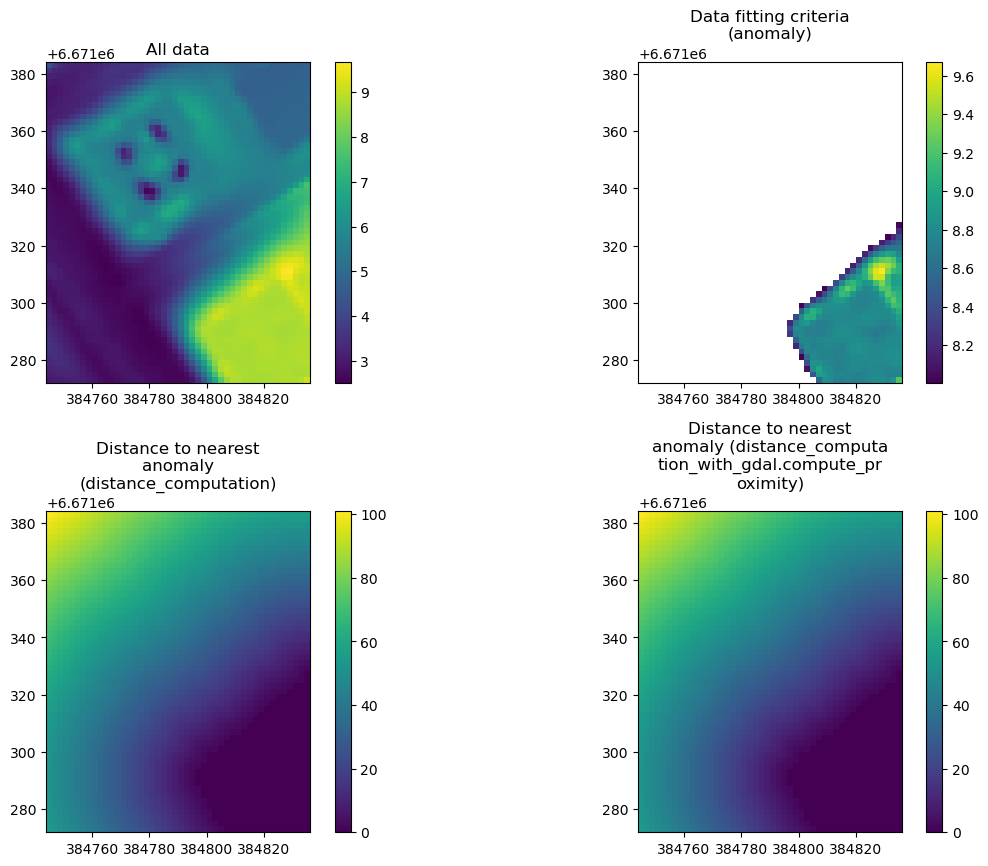

In [4]:
_plot_distance_example(threshold_criteria_value=8.0, threshold_criteria="higher")

The time taken by distance_to_anomaly function to calculate the distance to anomaly is = 0.689572811126709 seconds
The time taken by gdal.compute_proximity function to calculate the distance to anomaly is = 0.0010004043579101562 seconds


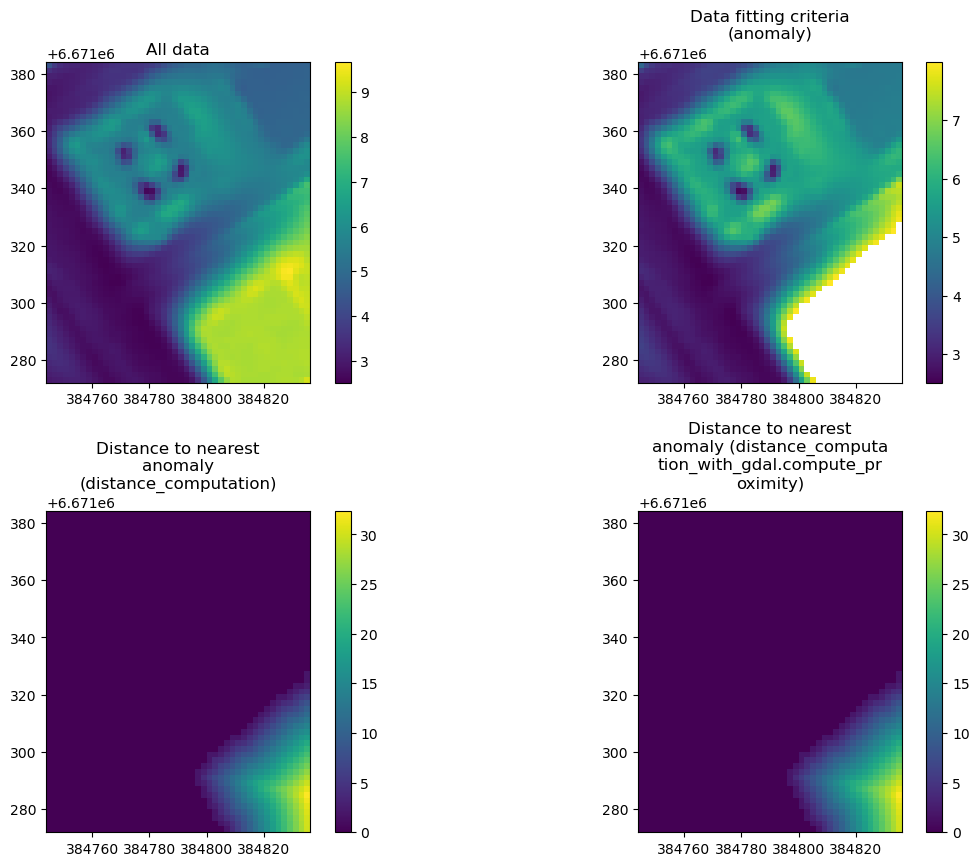

In [5]:
_plot_distance_example(threshold_criteria_value=8.0, threshold_criteria="lower")

The time taken by distance_to_anomaly function to calculate the distance to anomaly is = 0.36331868171691895 seconds
The time taken by gdal.compute_proximity function to calculate the distance to anomaly is = 0.0013973712921142578 seconds


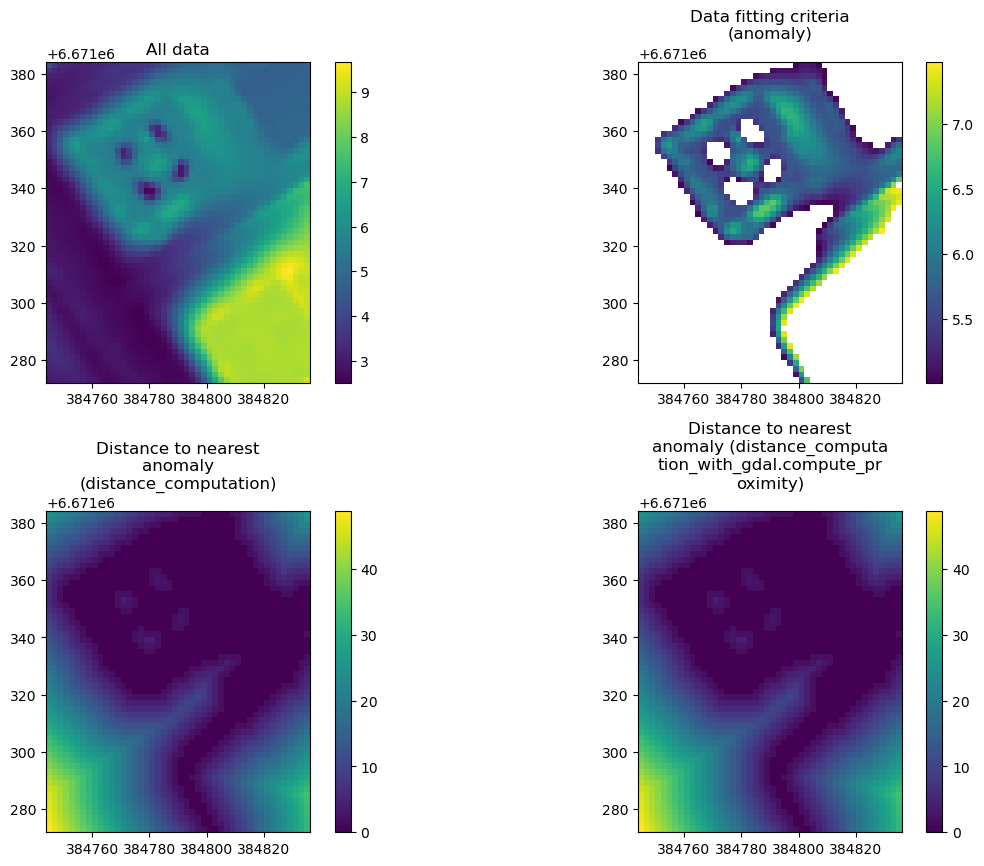

In [6]:
_plot_distance_example(
    threshold_criteria_value=(5.0, 7.5), threshold_criteria="in_between"
)

The time taken by distance_to_anomaly function to calculate the distance to anomaly is = 0.518155574798584 seconds
The time taken by gdal.compute_proximity function to calculate the distance to anomaly is = 0.001996755599975586 seconds


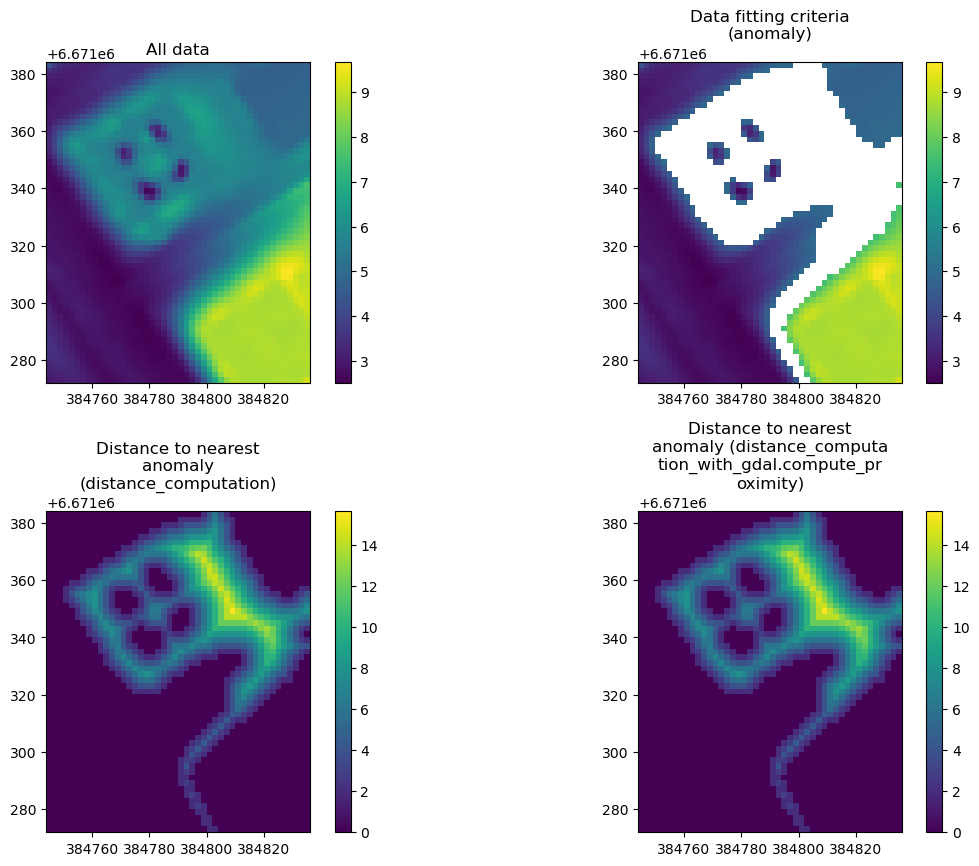

In [7]:
_plot_distance_example(
    threshold_criteria_value=(5.0, 7.5), threshold_criteria="outside"
)